# Set carbon emission targets

In this notebook a target for the emission is set and the required tax rate is calculated. This involves inverting the model, and takes some time.  

In [64]:
# Import modelflow

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
%matplotlib inline

import matplotlib.pyplot as plt

from ipywidgets import interact,Dropdown,Checkbox
from IPython.display import display, clear_output,Latex, Markdown
import pandas as pd

import modelmf
import modeljupyter as mj
from modelvis import waterplot

from modelinvert import targets_instruments
from modelclass import model
model.widescreen()

model.scroll_off()

# Model inversion aka Target/instruments or Goal Seek 
In ordet to answer questions like: 

- Carbon tax level in order to achieve a certain level of CO2 emission (carbon emission model)
- How much capital has to be injected in order to maintain a certain GDP level in a stressed scenario? (Bank Stress test model)
- How much loans has to be shredded by the banks in order to maintain a minimum level of capital (slim to fit)? (Bank Stress test model) 
- How much capital has to be injected in order to keep all bank above a certain capital threshold ? (Bank Stress test model) 
- What probability of transmission result in infected 2 weeks later (Covid-19 infection model) 

The model instance created by is capable to **"invert"** a model. 

To use the terminology of Tinbergen(1955) that is to calculate the value of some exogenous variables - **the instruments** which is required in order to achieve a certain target value for some endogenous variables - **the targets**. 

To use the terminology of Excel it is a goal/seek functionality with multiple cells as goals and multiple cells as targets.  

The problem can be thought as follows: From the generic description of a model: $\textbf{y}_t= \textbf{F}(\textbf{x}_{t})$. Here $\textbf{x}_{t}$ are all predetermined variables - lagged endogenous and all exogenous variables. 

It can be useful to allow a **delay**, when finding the instruments. In this case we want to look at  $\textbf{y}_t= \textbf{F}(\textbf{x}_{t-delay})$ 

Think of a condensed model ($\textbf{G}$) with a few endogenous variables($\bar{\textbf{y}}_t$):
the targets and a few exogenous variables($\bar{\textbf{x}}_{t-delay}$): the instrument variables. All the rest of the predetermined variables are fixed:  
$\bar{\textbf{y}}_t= \textbf{G}(\bar{\textbf{x}}_{t-delay})$

If we invert G we have a model where  instruments are functions of targets:
$\bar{\textbf{x}_{t-delay}}= \textbf{G}^{-1}(\bar{\textbf{y}_{t}})$. Then all we have to do is to find
$\textbf{G}^{-1}(\bar{\textbf{y}_{t}})$

To do this analytical is not possible for large model. Instead the probelm is solved numerical with the Newton-Raphson method. Takes a lot of calculations, but doable. 

### And how to solve for the instruments 
For most models $\bar{\textbf{x}}_{t-delay}= \textbf{G}^{-1}(\bar{\textbf{y}_{t}})$ do not have a nice close form solution. However it can be solved numerically. We  turn to Newton–Raphson method.

So $\bar{\textbf{x}}_{t-delay}= \textbf{G}^{-1}(\bar{\textbf{y}_{t}^*})$ will be found using :

for $k$ = 1 to convergence  

>$\bar{\textbf{x}}_{t-delay,end}^k= \bar{\textbf{x}}_{t-delay,end}^{k-1}+ \textbf{J}^{-1}_t \times (\bar{\textbf{y}_{t}^*}-
\bar{\textbf{y}_{t}}^{k-1})$

>$\bar{\textbf{y}}_t^{k}= \textbf{G}(\bar{\textbf{x}}_{t-delay}^{k})$

convergence: $\mid\bar{\textbf{y}_{t}^*}-
\bar{\textbf{y}_{t}}
\mid\leq \epsilon$

Now we just need to find: 

$\textbf{J}_t = \frac{\partial \textbf{G} }{\partial \bar{\textbf{x}}_{t-delay}}$

A number of differentiation methods can be used (symbolic, automated or numerical). ModelFlow uses numerical differentiation, as it is quite simple and fast.

$\textbf{J}_t \approx \frac{\Delta \textbf{G} }{\Delta \bar{\textbf{x}}_{t-delay}}$

That means that we should run the model one time for each instrument, and record the 
effect on each of the targets, then we have $\textbf{J}_t$ 

In order for $\textbf{J}_t$ to be invertible there has to be the same number of targets and instruments. 

However, each instrument can be a basket of exogenous variable. They will be adjusted in fixed proportions. This can be useful for instance when using bank leverage as instruments. Then the leverage instrument can consist of several loan types.  

You will notice that the level of $\bar{\textbf{x}}$ is updated (by  $\textbf{J}^{-1}_t \times (\bar{\textbf{y}_{t}^*}-
\bar{\textbf{y}_{t}}^{k-1})$) in all periods from $t-delay$ to $end$, where $end$ is the last timeframe in the dataframe. This is useful for many applications including calibration of disease spreading models and in economic models, where the instruments are level variable (i.e. not change variables). If this is not suitable, it can be changed in a future release. 

The target/instrument functionality is implemented in the python class `targets_instruments` specified in **ModelFlows** `modelinvert` module.  

### An example
The workflow is as follow:

1.  Define the targets
2.  Define the instruments 
3.  Create a target_instrument class istance
4. Solve the problem 

Step one is to define the targets. This is done by creating a dataframe where the target values are set. 

# How for each country to achieve a 30 percent reduction in emission(2050) relative to "business as Usual"

## Construct a trajectory with the target reduction in 2050

From the reduction\_in\_ percent the target $CO^2$ emission in 2050 is calculated:

$target\_CO^{2\_country}_{t = 2050} = CO^{2\_country}_{t = 2050} \times (1-reduction\_in\_ percent/100)$

The yearly growth rate from 2022 to 2050 consistent with the target in 205 is calculated: 

$target\_growth\_factor = \left(\dfrac{CO^{2\_target}_{t = 2050}}{CO^{2}_{t = 2022}}\right)^{\dfrac{1}{2050-2022}}$

The target emission in 2022 is initialized to the "Business as Usual" emission: 

$target\_CO^{2\_country}_{t = 2022} =CO^{2\_country}_{t = 2022}$

Now we can calculate the target emissions from 2023 to 2050: 

$target\_CO^{2\_country}_{t} = Target\_CO^{2\_country}_{t-1} \times target\_growth\_factor \hspace{5 mm} t=2023, \cdots , 2050$

# Load model and data, and run 

In [66]:
masia,baseline = model.modelload('Asia_sep7.pcim',run=1,silent=1)
from inject import inject
inject(masia)  
masia.lastdf = masia.basedf.copy()

# Parameters in this simulation 
Singapore won't solve. So it is excluded 


In [67]:
countries_of_interest = [country for country in masia.countries_ASEAN if country not in ['SGP']]
                         
instruments = [[f'{country}_GCARBR_A'] for country in countries_of_interest]
target_var  = [f'{country}_CO2' for country in countries_of_interest]
delay = 2
reduction_percent = 30 
countries_of_interest

['BRN', 'KHM', 'IDN', 'LAO', 'MYS', 'MMR', 'PHL', 'THA', 'VNM']

# Emission in Business as usual scenario

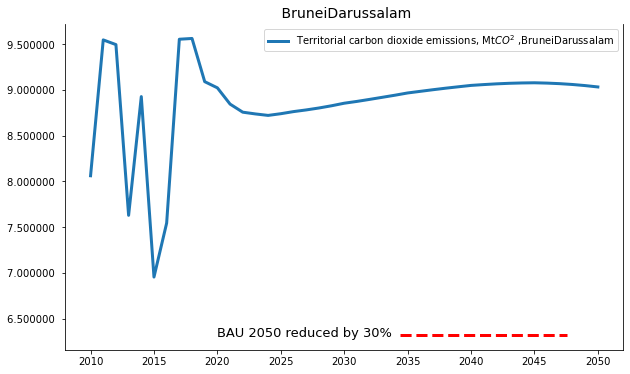

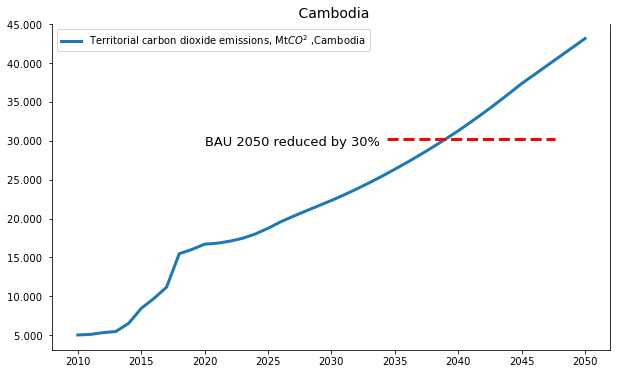

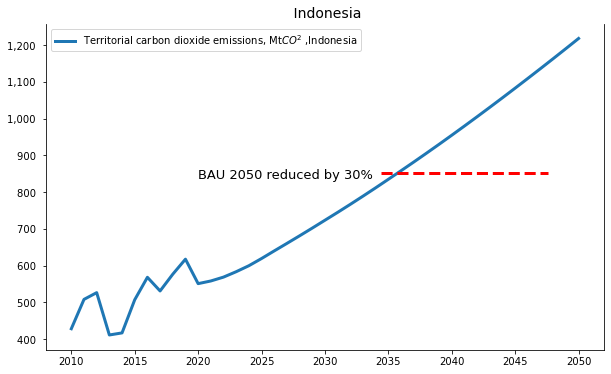

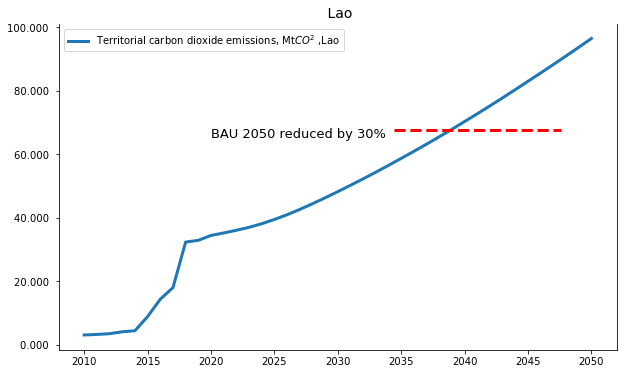

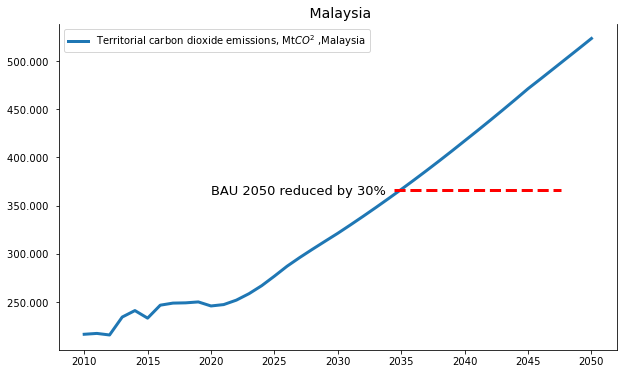

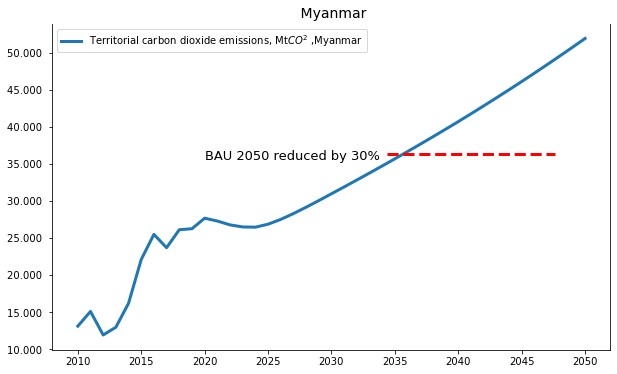

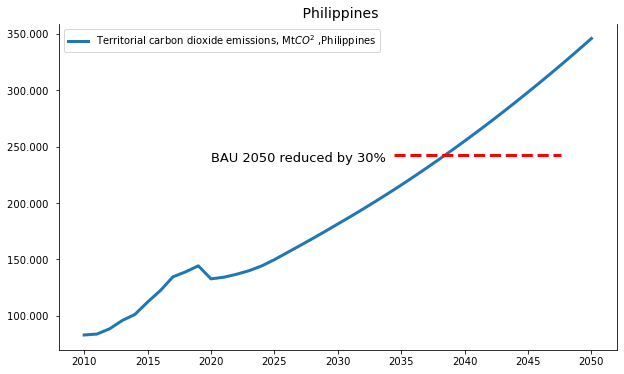

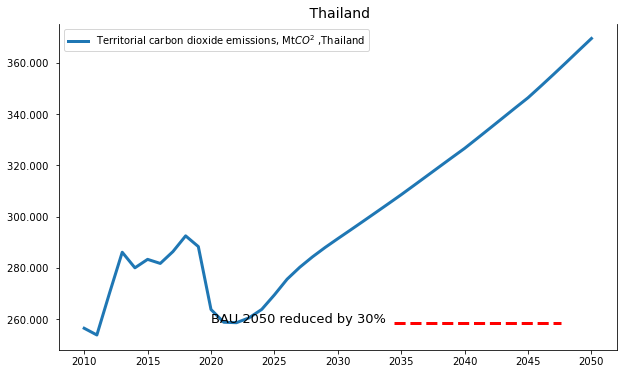

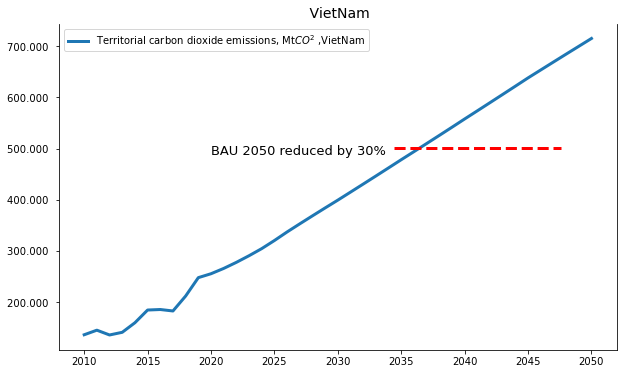

In [68]:
for t in target_var:
    fig = model.plot_basis(masia.get_a_country(t),df = masia.basedf.loc[2010:,[t]].rename(columns=masia.var_description),legend=1);
    fig.axes[0].axhline( (t_2050:=masia.basedf.loc[2050:,t].values*(1-reduction_percent/100)),xmin=0.6,xmax = 0.9,linewidth=3, color='r', ls='dashed') 
    fig.axes[0].annotate(f'BAU 2050 reduced by {reduction_percent}%', xy=(2020,t_2050*1.015 ),
                                     fontsize=13, va='top')



# The instrument variables

In [69]:
print(instruments)

[['BRN_GCARBR_A'], ['KHM_GCARBR_A'], ['IDN_GCARBR_A'], ['LAO_GCARBR_A'], ['MYS_GCARBR_A'], ['MMR_GCARBR_A'], ['PHL_GCARBR_A'], ['THA_GCARBR_A'], ['VNM_GCARBR_A']]


# Carbon tax in Business as usual scenario

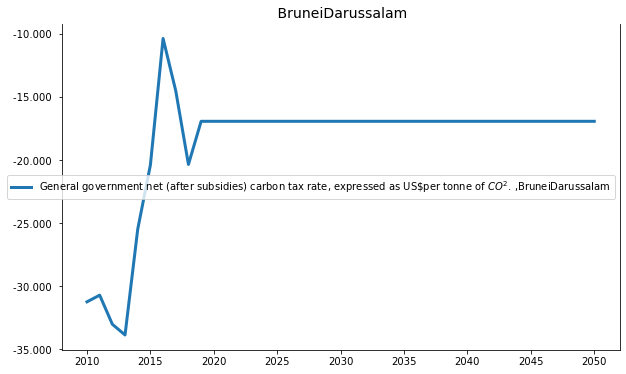

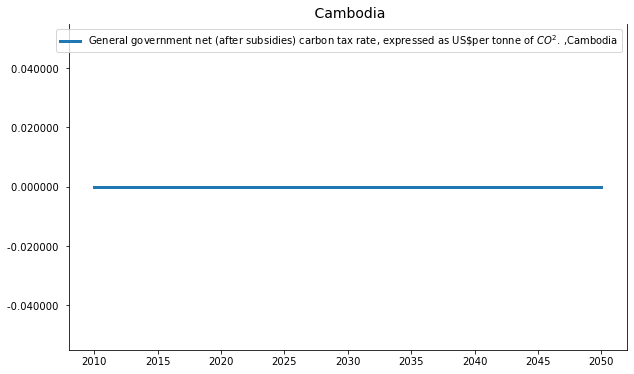

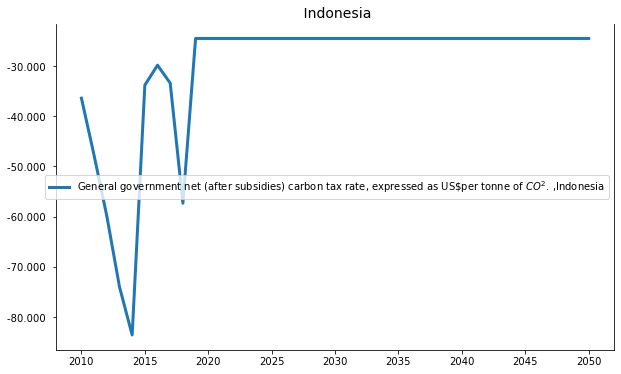

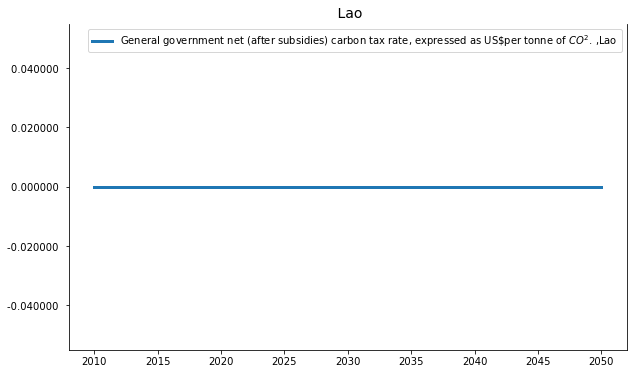

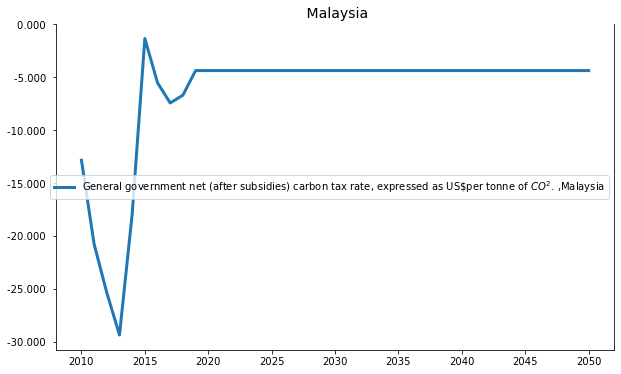

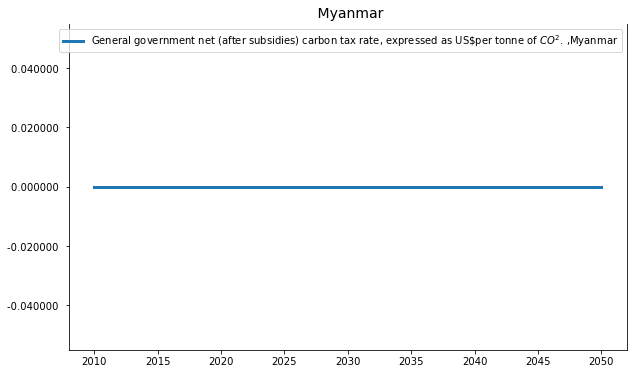

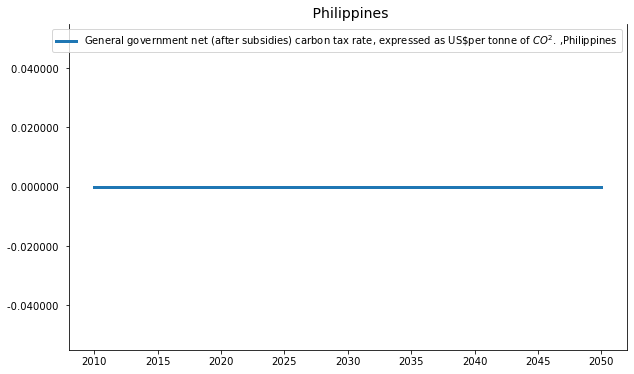

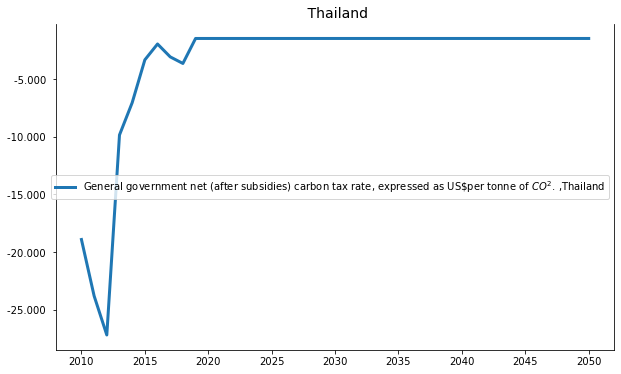

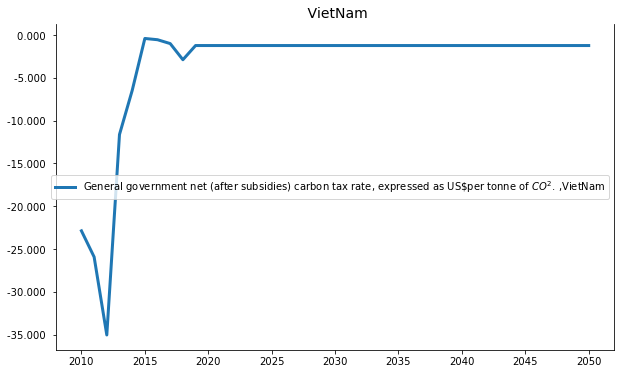

In [70]:
for i in instruments: 
    tax = [i[0][:-2]]
    model.plot_basis(masia.get_a_country(tax[0]),df = masia.basedf.loc[2010:,tax].rename(columns=masia.var_description),legend=1);

# Lets look at the impact of increasing the tax with \$10/tonne  in 2022

In [71]:
experiment = baseline.copy()
experiment.loc[2022,instrumentlist]= experiment.loc[2022,(instrumentlist := [i[0] for i in instruments])] + 10 
result = masia(experiment,progressbar = 0,silent=1)

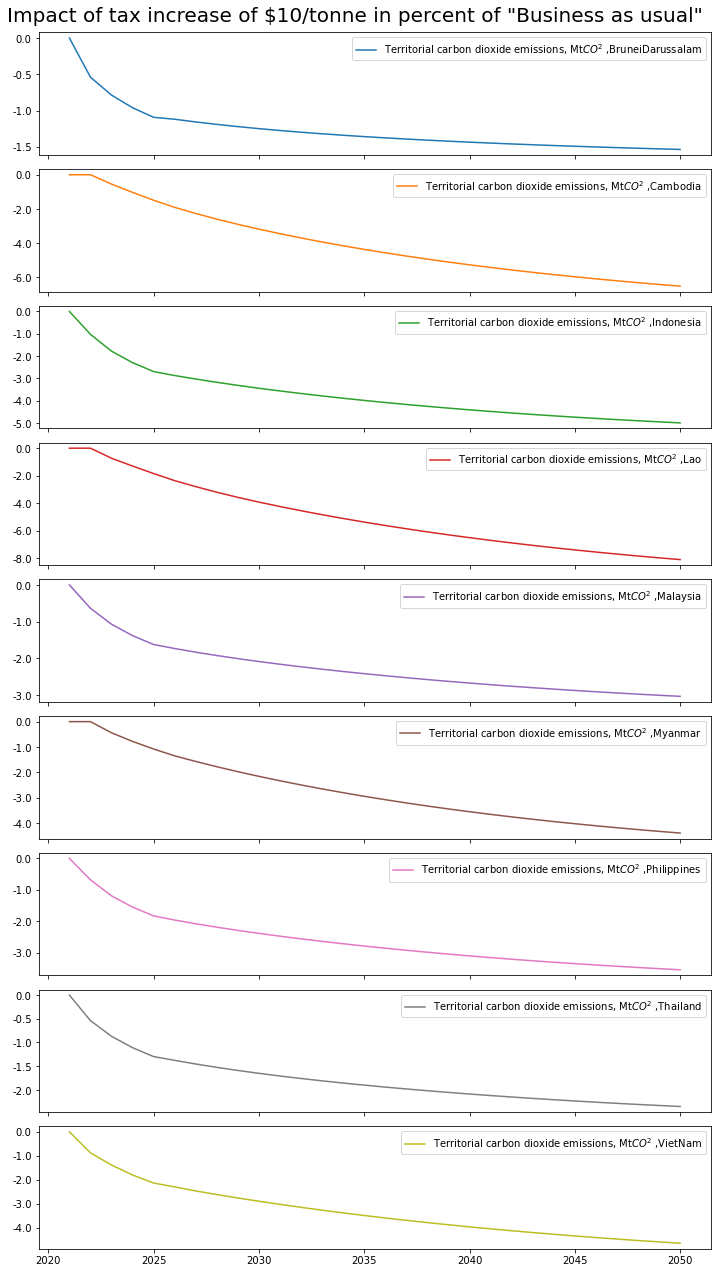

In [72]:
masia[target_var].difpctlevel.mul100.rename().plot(colrow  = 1,title = 'Impact of tax increase of \$10/tonne in percent of "Business as usual"  ',top=0.96,sharey=0,dec=2);
end_pct = masia[target_var].difpctlevel.mul100.df.loc[2050,:]
    

# The impact in selectet years  of increasing the tax with 10/tonne in 2022 in percent of BAU

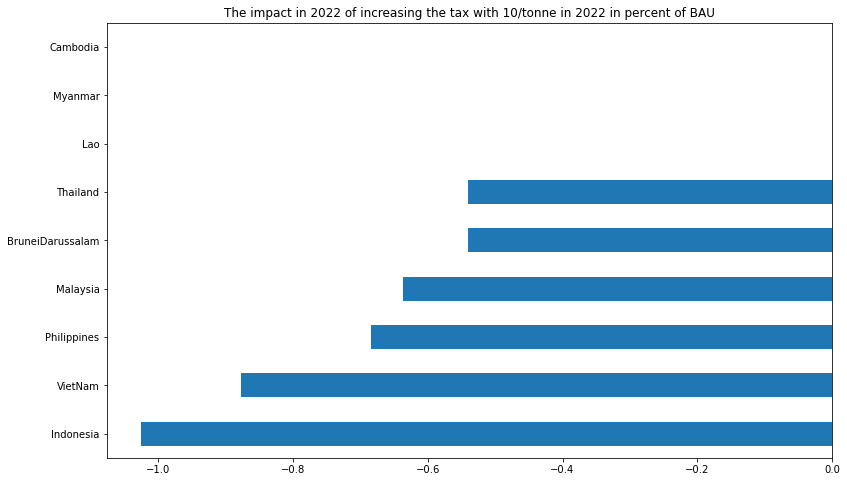

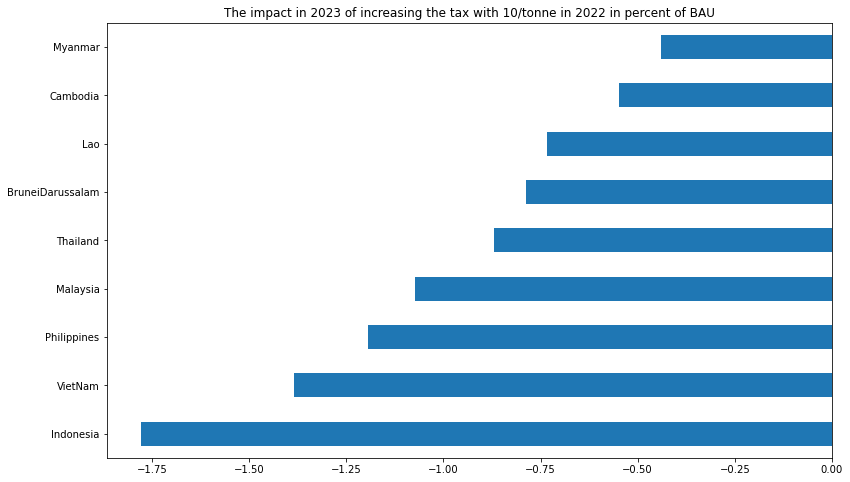

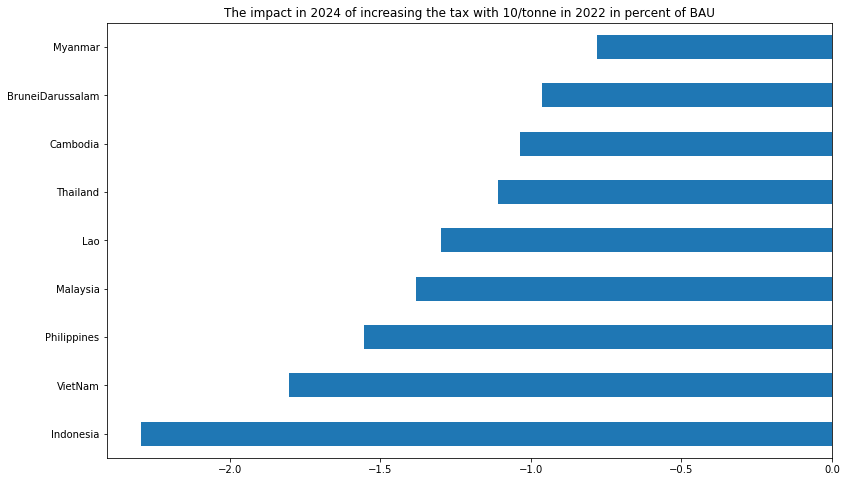

In [73]:

for year in [2022,2023,2024]:
    end_pct = masia[target_var].difpctlevel.mul100.df.loc[year,:]
    fig= end_pct.T.rename(masia.get_a_country).sort_values().plot(kind='barh',figsize = (13,8),title=f'The impact in {year} of increasing the tax with 10/tonne in 2022 in percent of BAU')
    plt.show()

# Find for each country the emission growthrate which is consistent with a the desired reduction in emmision in 2050 

In [74]:
bau_2050 = baseline.loc[2050, target_var]
bau_2022  = baseline.loc[2022, target_var]

org_growthrate = (bau_2050/bau_2022)**(1/(2050-2022))
org_growthrate.name = 'Original growth rate'

target_2050 = bau_2050*(1-reduction_percent/100)
target_2050.name= 'target'

target_growthrate = (target_2050/bau_2022)**(1/(2050-2022))
target_growthrate.name = 'Target growth rate'

In [75]:
target_growth_values = list(target_growthrate.values)

In [76]:
target_before = baseline[target_var].loc[2022:,:]
calclines = '\n'.join(f'{t} = {t}(-1) * {v}' for t,v in zip(target_var,target_growth_values))
target = target_before.mfcalc(calclines).loc[2022+delay:,:]

# Check that the target match the reduced BAU

In [85]:
outdf = pd.DataFrame([bau_2022,bau_2050,target_2050,target.loc[2050,: ]]).T
outdf.columns=['BAU 2022','BAU 2050','BAU 2050 reduced','Target in 2025']
print(outdf)

           BAU 2022     BAU 2050  BAU 2050 reduced  Target in 2025
BRN_CO2    8.755168     9.030840          6.321588        6.321588
KHM_CO2   17.091480    43.151550         30.206085       30.206085
IDN_CO2  568.703700  1218.279002        852.795301      852.795301
LAO_CO2   35.975220    96.393180         67.475226       67.475226
MYS_CO2  251.956600   523.385200        366.369640      366.369640
MMR_CO2   26.750860    51.907150         36.335005       36.335005
PHL_CO2  136.737200   345.827201        242.079040      242.079040
THA_CO2  258.589600   369.446700        258.612690      258.612690
VNM_CO2  277.603300   715.051501        500.536051      500.536051


# Setup the Target/instrument device

In [80]:
t_i_baseline = baseline.copy()
t_i = targets_instruments(databank=t_i_baseline,targets=target,instruments=instruments,
                          model=masia,DefaultImpuls=10,defaultconv=0.5,varimpulse=True,nonlin=4,silent=1)

# Run the device. 
And fetch a cup of coffee. 
Serious calculations are to be performed

In [81]:
t_i.debug=0
res = t_i(delay=delay,shortfall=0)

Finding instruments :   0%|          | 0/27

# So close to the target
Below the difference between the target $co^2$ and the simulation result

This should reflect the size of defaultconv in the target_instrument call 

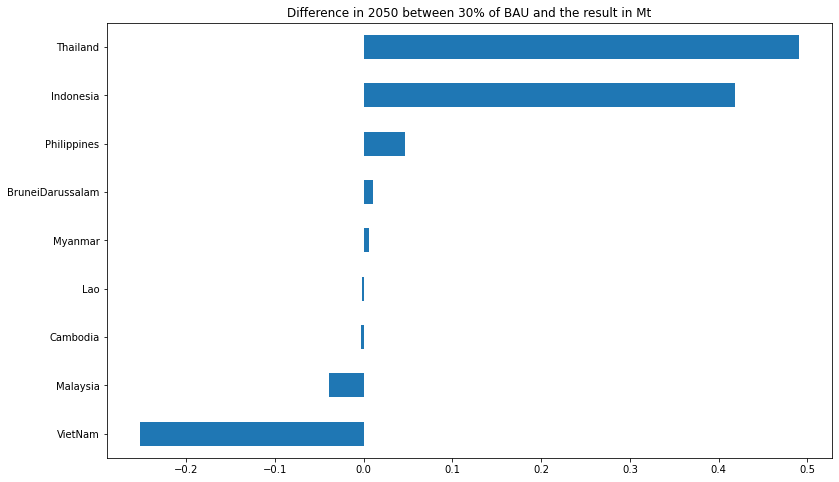

In [82]:
fig= (masia.lastdf.loc[2050,target_var]-target.loc[2050,:]).rename(masia.get_a_country).sort_values().plot(kind='barh',figsize = (13,8),title=f'Difference in 2050 between {reduction_percent}% of BAU and the result in Mt')
plt.show()

# Emission and tax in "Business as usual" and target run  

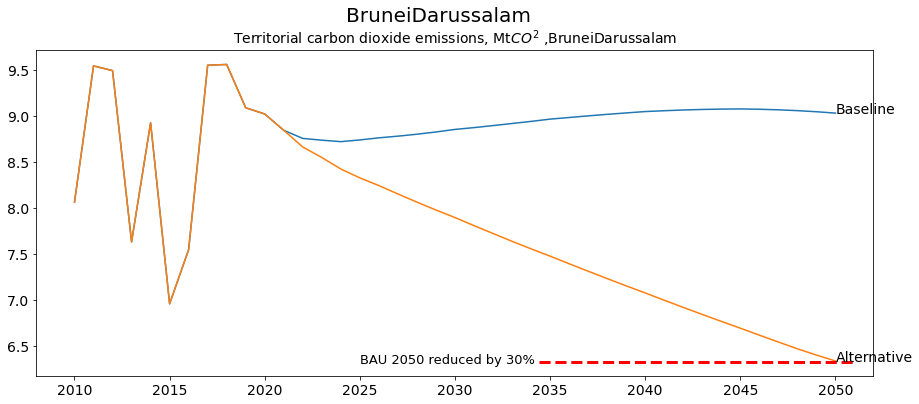

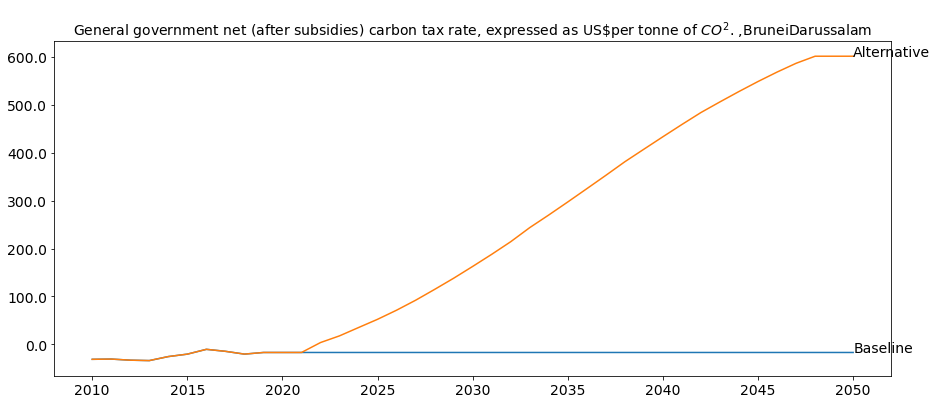

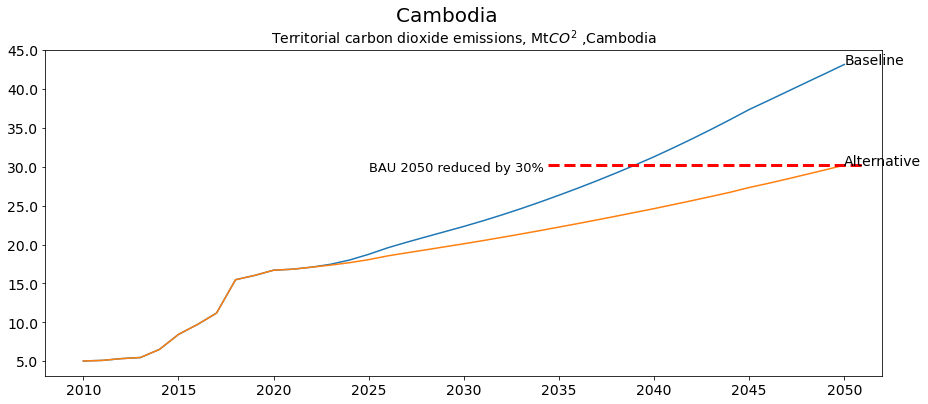

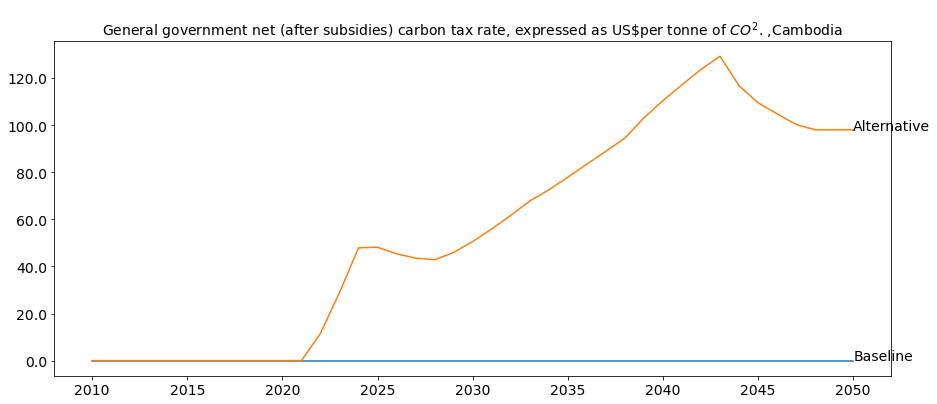

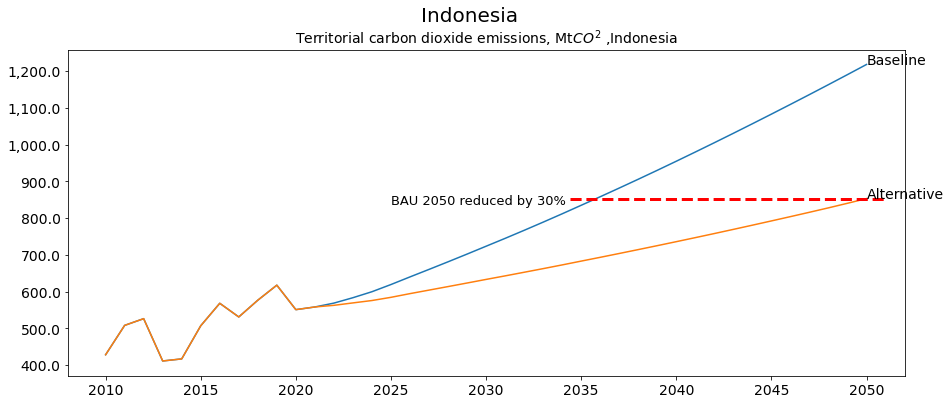

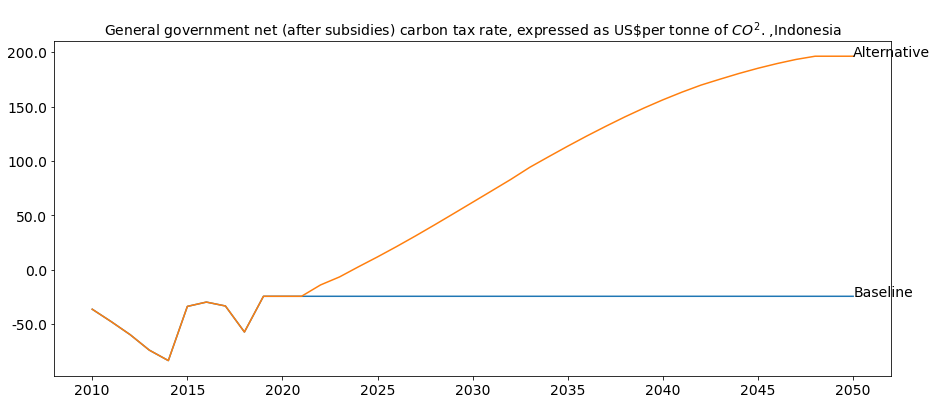

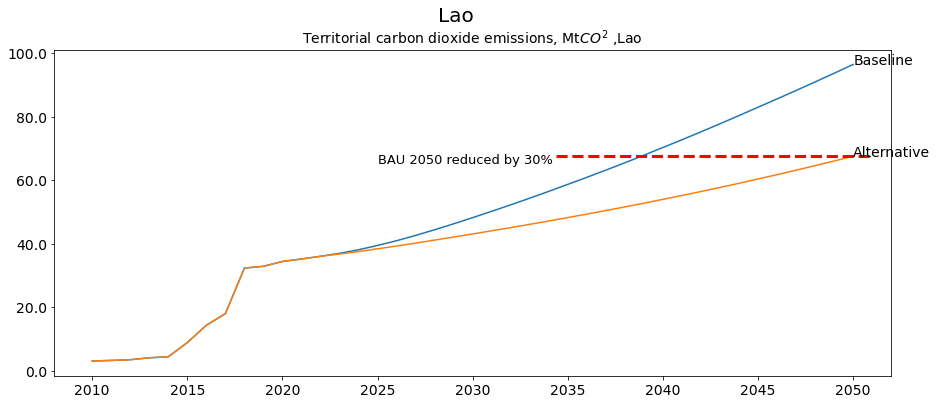

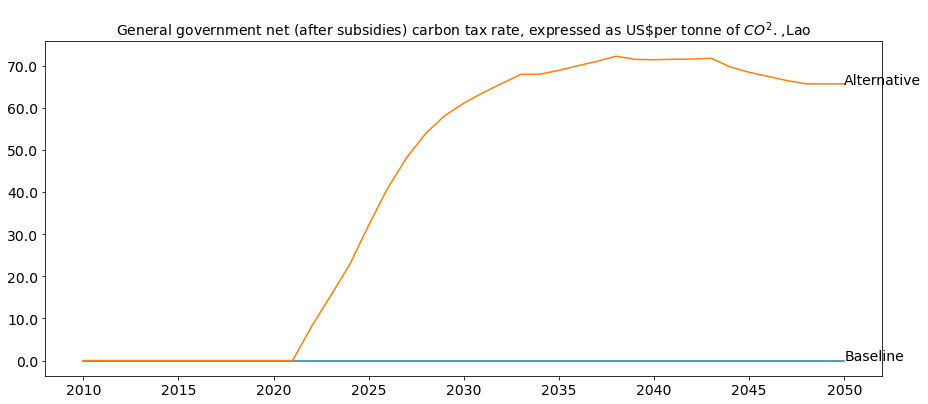

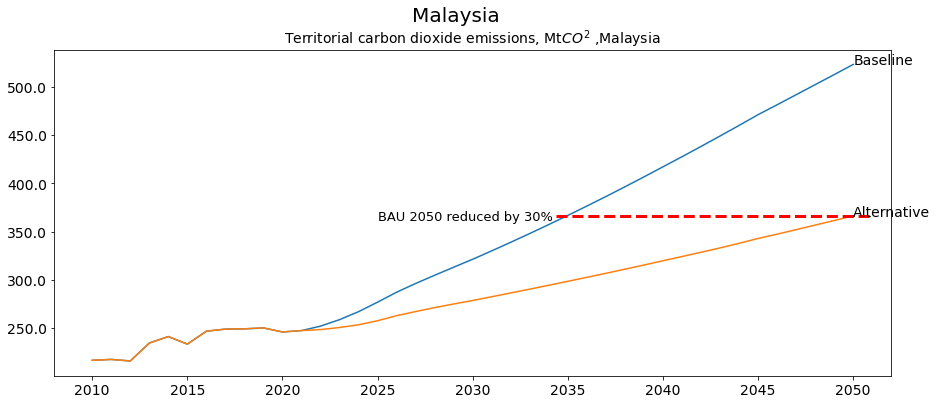

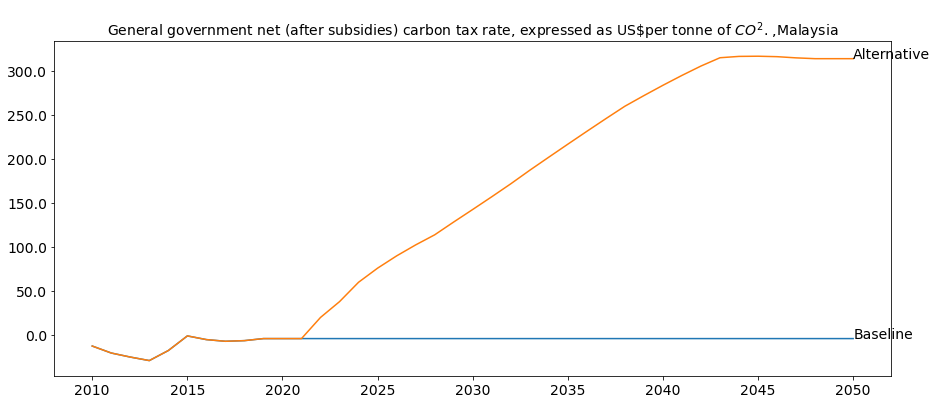

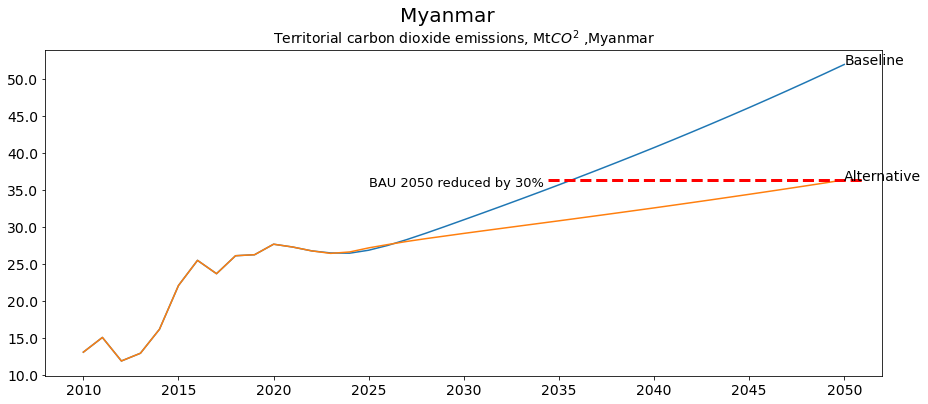

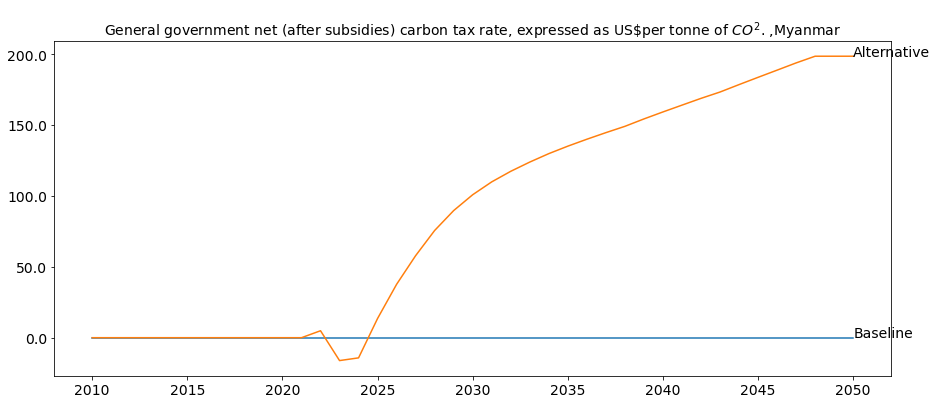

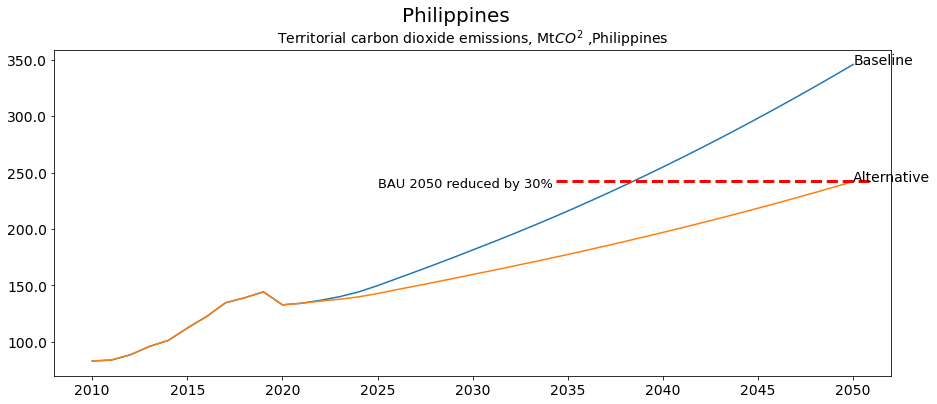

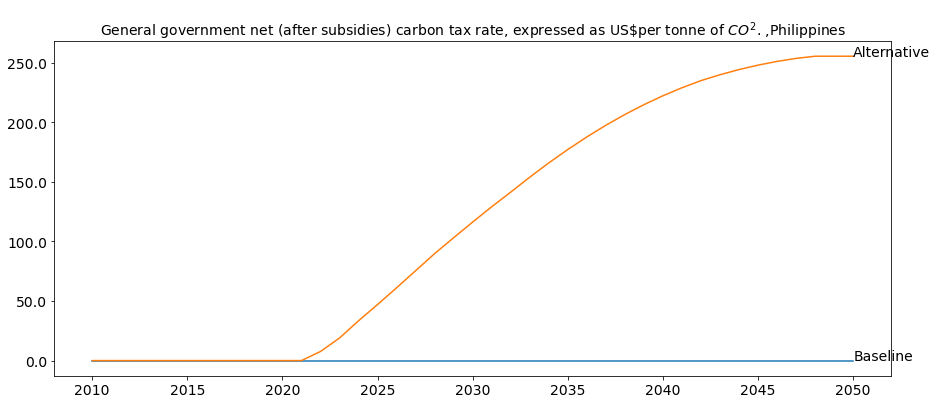

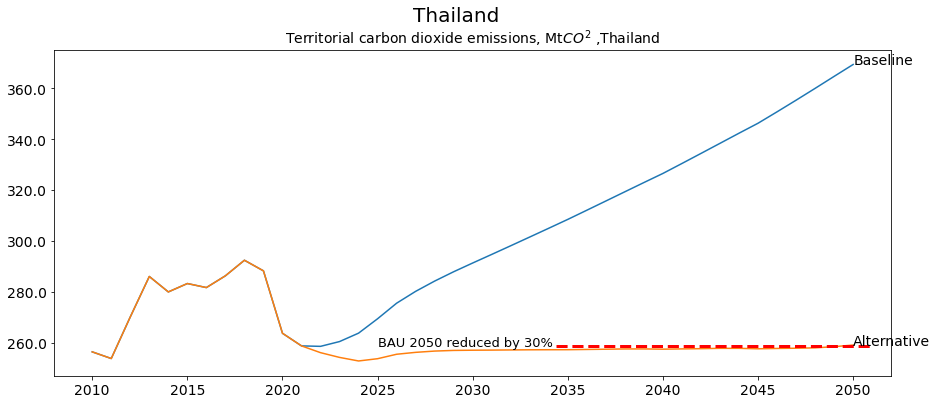

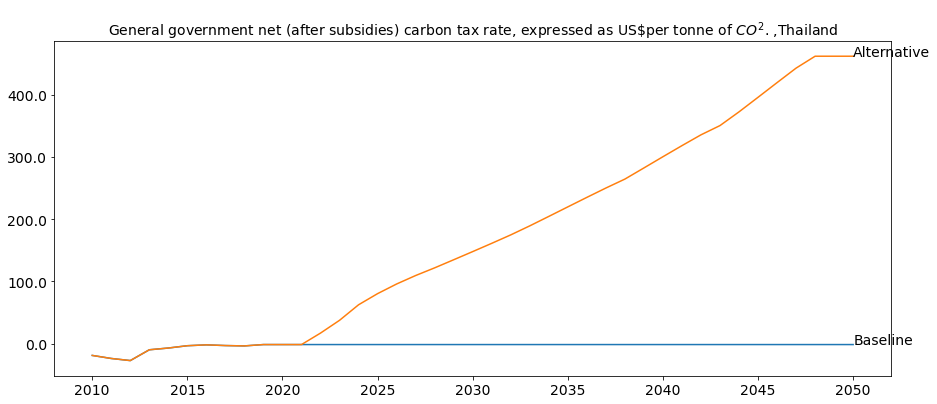

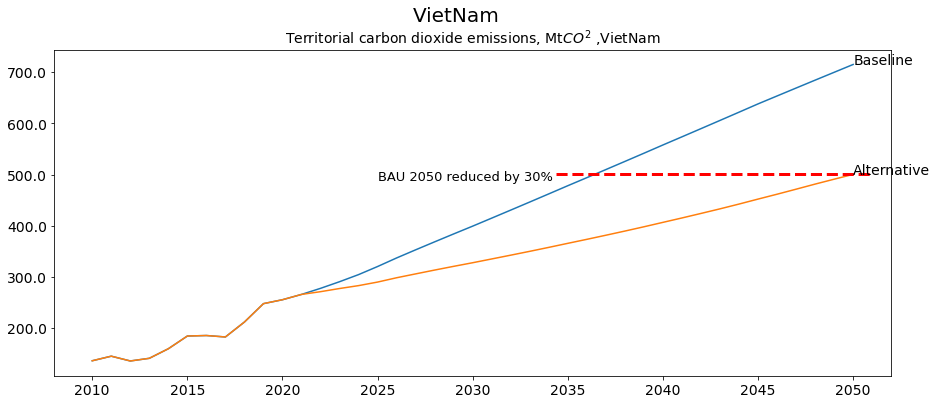

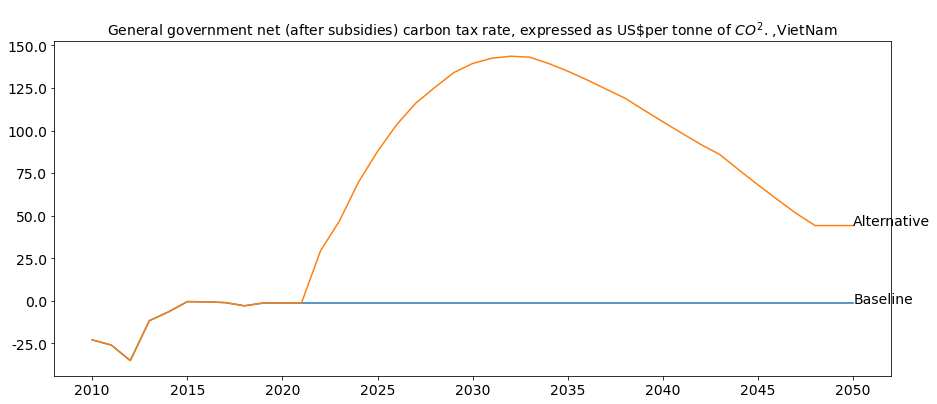

In [83]:
with masia.set_smpl(2010,2050):
    for country,value  in zip(countries_of_interest,target_2050):
        fig = masia[f'{country}_co2' ].plot_alt(title=f'{masia.iso_dict[country]} ',top=0.88);   
        fig.axes[0].axhline( value,xmin=0.6,xmax = 0.98,linewidth=3, color='r', ls='dashed') 
        fig.axes[0].annotate(f'BAU 2050 reduced by {reduction_percent}%', xy=(2025,value*1.015 ),
                                     fontsize=13, va='top')
        
        masia[f'{country}_GCARBR' ].plot_alt(title=f' ',top=0.90);